In [19]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T163211Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5a8ceb24df25ff9eb44f5abd29c7a40b8d45960e83137657e2d0baebd3109baf83d87b2485f2e2fa6a664d67f99d7c694a363c7b7038cb8740e2c5d9c71227723ea2f9ab977349be4ca09d717d7fa9874cfd3df98490b14b4192537be46096e416ebff68d93fd521b3d8d25bec786e6a8b9df132b1b6d0140c9f065059738973276ed89c0a35d2742754ccc941dc174099baf4570a38e0aa76074984607980f62ee2f25025c31873bb7516fa53786546e1e9fc66def4b7bf5c19b0e0e52918847becce71c06f000eaab2e882a16c63bda51b6605103667d948679a2c48c9c70fd3cbd5e5522face89785cffa41a6170a40630d059d3fa12a0b7e09362601006f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
Data source import complete.


### Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

plt.style.use("ggplot")

import librosa
import librosa.display

from IPython.display import Audio

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Load the Dataset

In [4]:
paths = []
labels = []

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split("_")[-1]
        label = label.split(".")[0]
        labels.append(label.lower())

### Creating a dataframe

In [6]:
df = pd.DataFrame()

In [7]:
df["speech"] = paths
df["label"] = labels

In [8]:
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [9]:
df["label"].value_counts()

label
fear       800
ps         800
disgust    800
angry      800
happy      800
sad        800
neutral    800
Name: count, dtype: int64

### Exploratory Data Analysis

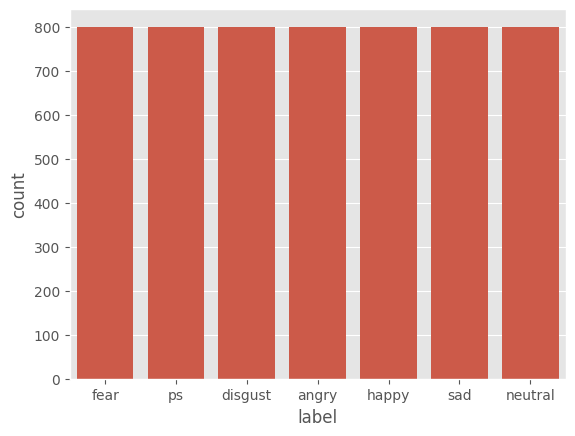

In [10]:
sns.countplot(data = df, x = "label")
plt.show()

Inference <br>
There is no requirement for class balancing

In [11]:
def waveplot(data, sample_rate, emotion):
    plt.figure(figsize = (10, 4))
    plt.title(emotion, size = 20)

    librosa.display.waveshow(y = data, sr = sample_rate)
    plt.show()

In [12]:
def spectogram(data, sr, emotion):

    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))

    plt.figure(figsize = (10, 4))
    plt.title(emotion, size = 20)

    librosa.display.specshow(data = xdb, sr = sr, x_axis = "time", y_axis = "hz")
    plt.show()

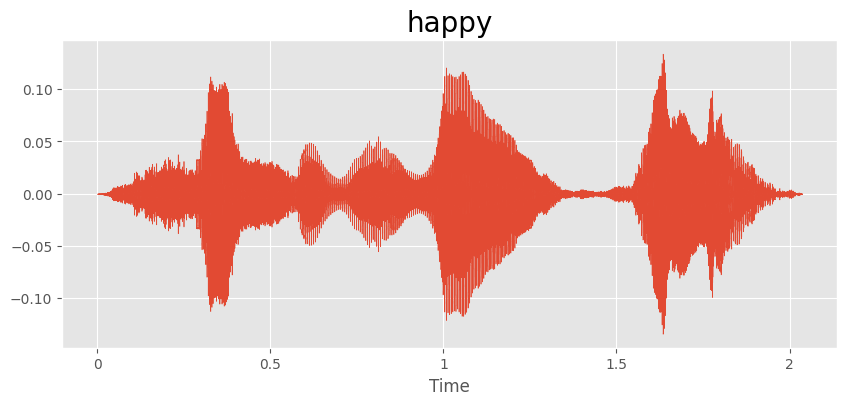

In [13]:
emotion = "happy"
path = df["speech"][df["label"] == emotion].reset_index()["speech"][259]
data, sample_rate = librosa.load(path)

waveplot(data, sample_rate, emotion)

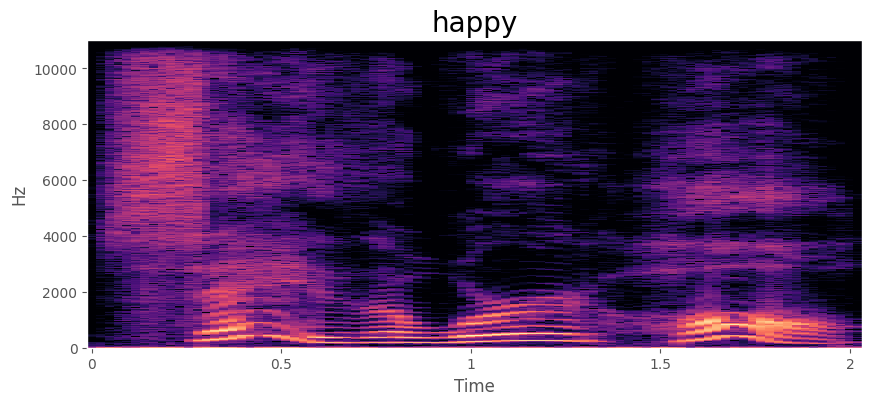

In [14]:
spectogram(data, sample_rate, emotion)

In [15]:
Audio(path)

### Feature Extraction

In [16]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [17]:
extract_mfcc(df["speech"][0])

array([-4.2654343e+02,  9.9821640e+01,  1.0113350e+01, -2.0916946e+01,
       -9.0404749e+00, -5.9253263e+00, -5.6358643e+00, -2.2024022e-01,
       -2.4785896e+01, -2.7312748e+00, -2.3918745e+01, -1.1521912e+01,
        4.0061066e-01, -7.2986903e+00, -8.0740613e-01,  3.6449125e+00,
       -6.2448173e+00, -4.8665676e-01, -3.1126497e+00, -4.9620047e+00,
        3.2052810e+00,  1.6877171e+01,  2.5152178e+01,  3.4150848e+01,
        2.9859129e+01,  2.4594255e+01,  5.4943585e+00,  1.9939798e+00,
       -1.0835984e+00,  4.6735444e+00,  2.4430160e-01,  3.2184522e+00,
       -6.6805868e+00, -2.9665625e+00,  3.6404274e+00,  4.9224720e+00,
       -1.1121324e+01,  4.3177802e-02, -7.1890659e+00,  4.0101600e-01],
      dtype=float32)

In [18]:
X_mfcc = df["speech"].apply(lambda x: extract_mfcc(x))

In [20]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [21]:
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
encoder = OneHotEncoder()
y = encoder.fit_transform(df[["label"]])

y = y.toarray()

In [24]:
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Build our LSTM Model

In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [26]:
model = Sequential(
    [
        LSTM(123, return_sequences = False, input_shape = (40, 1)),
        Dense(16, activation = 'relu'),
        Dropout(0.2),
        Dense(8, activation = 'relu'),
        Dropout(0.2),
        Dense(7, activation = 'softmax')
    ]
)

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 123)               61500     
                                                                 
 dense (Dense)               (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 7)                 63        
                                                                 
Total params: 63683 (248.76 KB)
Trainable params: 63683 

### Train the Model

In [29]:
training = model.fit(X, y, validation_split = 0.2, epochs = 80, batch_size = 512, shuffle = True)

Epoch 1/80
9/9 [==============================] - 7s 385ms/step - loss: 1.8880 - accuracy: 0.2382 - val_loss: 1.8035 - val_accuracy: 0.3830
Epoch 2/80
9/9 [==============================] - 4s 421ms/step - loss: 1.7061 - accuracy: 0.3013 - val_loss: 1.6365 - val_accuracy: 0.5375
Epoch 3/80
9/9 [==============================] - 3s 306ms/step - loss: 1.5403 - accuracy: 0.3699 - val_loss: 1.4511 - val_accuracy: 0.7054
Epoch 4/80
9/9 [==============================] - 3s 299ms/step - loss: 1.4068 - accuracy: 0.4402 - val_loss: 1.0992 - val_accuracy: 0.7875
Epoch 5/80
9/9 [==============================] - 3s 295ms/step - loss: 1.2554 - accuracy: 0.5141 - val_loss: 0.8679 - val_accuracy: 0.8080
Epoch 6/80
9/9 [==============================] - 3s 369ms/step - loss: 1.1190 - accuracy: 0.5719 - val_loss: 0.7354 - val_accuracy: 0.7946
Epoch 7/80
9/9 [==============================] - 3s 353ms/step - loss: 1.0048 - accuracy: 0.6187 - val_loss: 0.6348 - val_accuracy: 0.8152
Epoch 8/80
9/9 [====

In [30]:
epochs = list(range(80))

accuracy = training.history["accuracy"]
val_accuracy = training.history["val_accuracy"]

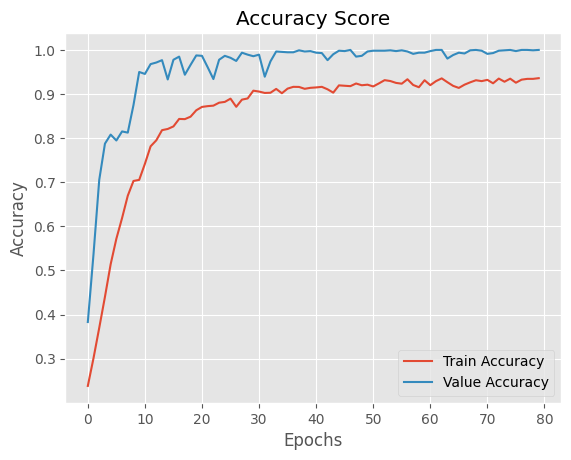

In [31]:
plt.plot(epochs , accuracy, label = 'Train Accuracy')
plt.plot(epochs , val_accuracy, label = 'Value Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Score")
plt.legend()
plt.show()

In [32]:
epochs = list(range(80))

loss = training.history["loss"]
val_loss = training.history["val_loss"]

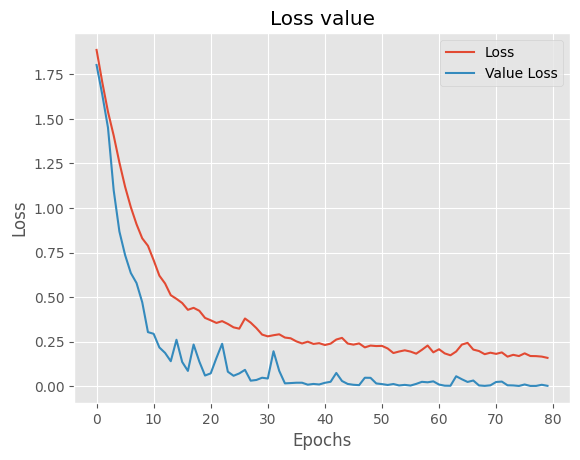

In [33]:
plt.plot(epochs , loss, label = 'Loss')
plt.plot(epochs , val_loss, label = 'Value Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss value")
plt.legend()
plt.show()